# Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
pd.set_option('display.max_colwidth', None)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read Data From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In this assignment, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. You can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8.

This is a large dataset something which is not covered yet in the class  but feel free to to look at the various techniques used to handle it.



   **Task**: Load the first 100,000 rows of data from the `train.csv` file located in the taxi dataset link on your uplevel. Skip the first row and use the second row as the header. Store the data in a variable named 'data'.

In [ ]:
# Replace the file_path with the path to your train.csv file
file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/train.csv'
data = pd.read_csv(file_path, header=0, nrows=100000)

# EDA & Feature Engineering

## Summary statistics and missing values

In [ ]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [ ]:
# Check for missing values
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
# Drop the rows with missing values
data.dropna(inplace=True)

In [ ]:
# Drop the rows with missing values
len(data)

100000

In [ ]:
# Check for missing values
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
# remove value where fare < 0
data = data[data["fare_amount"] > 0]

In [ ]:
len(data)

99988

**Task**: Convert the `pickup_datetime` column in the 'data' DataFrame to datetime type. Then, extract the year, month, day, and hour from the `pickup_datetime` column and create new columns named 'year', 'month', 'day', and 'hour' in the DataFrame

In [ ]:
# Convert the pickup_datetime column to datetime type
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract year, month, day, and hour from the pickup_datetime column
data['year'] =  data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] =  data['pickup_datetime'].dt.day
data['hour'] =  data['pickup_datetime'].dt.hour

data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7


## Distance Calculation

We will calculate distance with Haversine Formula

Pros of Haversine Formula:
1. Accuracy: The Haversine formula is more accurate for calculating distances between two points on the Earth's surface, as it takes into account the Earth's curvature.
2. Applicability: The Haversine formula is specifically designed for calculating great-circle distances on a sphere, making it suitable for geospatial applications, such as navigation and geodesy.
3. Consistent results: The Haversine formula provides consistent results for distances on a global scale, whereas the Euclidean distance can produce significant errors when used for long distances.

Cons of Haversine Formula:
1. Complexity: The Haversine formula is more complex than the Euclidean distance, requiring trigonometric functions and additional calculations.
2. Performance: Due to its complexity, the Haversine formula can be slower to compute than the Euclidean distance, especially when dealing with large datasets.
3. Assumptions: The Haversine formula assumes a perfect sphere, while the Earth is more of an oblate spheroid. This can lead to some inaccuracies, especially at high latitudes.

In [ ]:
!pip install haversine

In [ ]:
# Calculate the distance between pickup and dropoff coordinates using haversine formula
from haversine import haversine

**Task**: Write a function named `calculate_distance` that takes a row from the DataFrame as input. The function should calculate the distance between the pickup and dropoff coordinates using the haversine formula. The input row has the following columns: 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', and 'dropoff_longitude'. Return the calculated distance.

In [ ]:
def calculate_distance(row):
    pickup = (row['pickup_latitude'] ,row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'] ,row['dropoff_longitude'])
    return haversine(pickup, dropoff)

In [ ]:
#data['distance'] = data.apply(calculate_distance, axis=1)

# Drop the key and pickup_datetime columns as they are not needed for EDA
#data.drop(['key', 'pickup_datetime'], axis=1, inplace=True)

Time for some Geography

Latitude and longitude values are used to represent geographical coordinates on the Earth's surface. They are measured in degrees and have specific ranges that correspond to valid locations on Earth.

Latitude values range from -90 to +90 degrees, where -90 represents the South Pole, 0 represents the Equator, and +90 represents the North Pole.

Longitude values range from -180 to +180 degrees, where -180 corresponds to the Prime Meridian (which passes through Greenwich, London), and +180 corresponds to the 180th meridian, which is on the opposite side of the Earth.

These ranges are based on the Earth's geometry and are used to ensure that latitude and longitude values correspond to actual locations on the Earth's surface. If a latitude or longitude value is outside its respective range, it is considered invalid and most likely represents an error in the data.

In [ ]:
# Filter out rows with invalid latitude and longitude values
valid_latitude_range = (-90, 90)
valid_longitude_range = (-180, 180)

data = data[(data['pickup_latitude'].between(*valid_latitude_range)) &
            (data['pickup_longitude'].between(*valid_longitude_range)) &
            (data['dropoff_latitude'].between(*valid_latitude_range)) &
            (data['dropoff_longitude'].between(*valid_longitude_range))]

In [ ]:
len(data)

99985

In [ ]:
#let's rerun earlier code

data['distance'] = data.apply(calculate_distance, axis=1)

# Drop the key and pickup_datetime columns as they are not needed for EDA
data.drop(['key', 'pickup_datetime'], axis=1, inplace=True)

   **Task**: Create a histogram plot to visualize the distribution of the `fare_amount` column in the 'data' DataFrame. Use Seaborn's `histplot` function with kernel density estimation (kde) enabled. Add a title "Distribution of Fare Amount" and an x-axis label "Fare Amount". Display the plot using `plt.show()`.

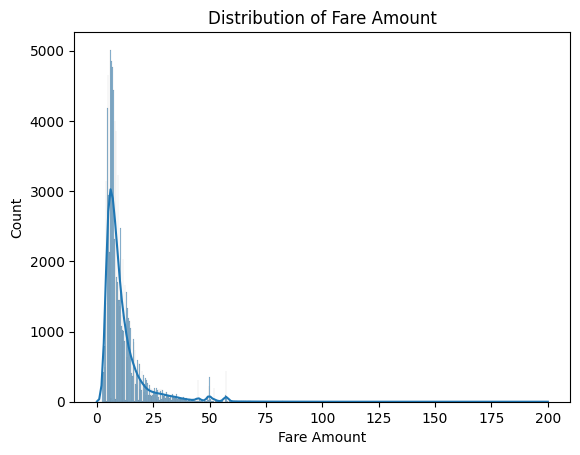

In [ ]:
# Plot the distribution of fare_amount

sns.histplot(data =data, x= 'fare_amount' ,kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.show()


In [ ]:
data[:10]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,1.030765
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,8.450145
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,1.389527
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,2.799274
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1.999160
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,6,9,3.787244
6,7.5,-73.980002,40.751662,-73.973802,40.764842,1,2012,11,20,20,1.555809
7,16.5,-73.951300,40.774138,-73.990095,40.751048,1,2012,1,4,17,4.155450
8,9.0,-74.006462,40.726713,-73.993078,40.731628,1,2012,12,3,13,1.253233
9,8.9,-73.980658,40.733873,-73.991540,40.758138,2,2009,9,2,1,2.849631


**Task**: Create a count plot to visualize the distribution of the `passenger_count` column in the 'data' DataFrame. Use Seaborn's `countplot` function. Add a title "Distribution of Passenger Count", an x-axis label "Passenger Count", and a y-axis label "Frequency". Display the plot using `plt.show()`.|


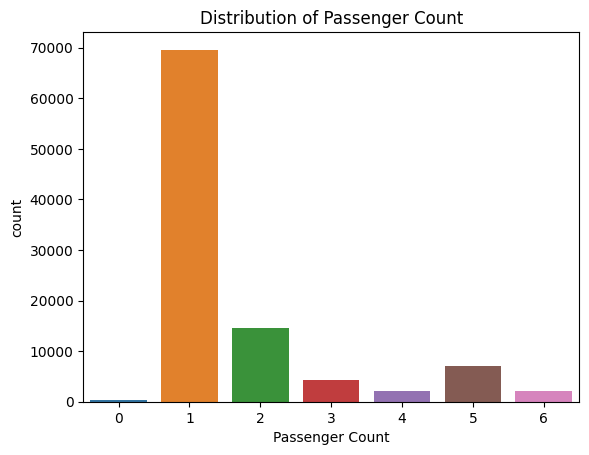

In [ ]:
# Plot the distribution of passenger_count

sns.countplot(x='passenger_count' , data= data)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.show()

**Task**: Create a histogram plot to visualize the distribution of the `distance` column in the 'data' DataFrame. Use Seaborn's `histplot` function with kernel density estimation (kde) enabled. Add a title "Distribution of Distance" and an x-axis label "Distance". Display the plot using `plt.show()`.

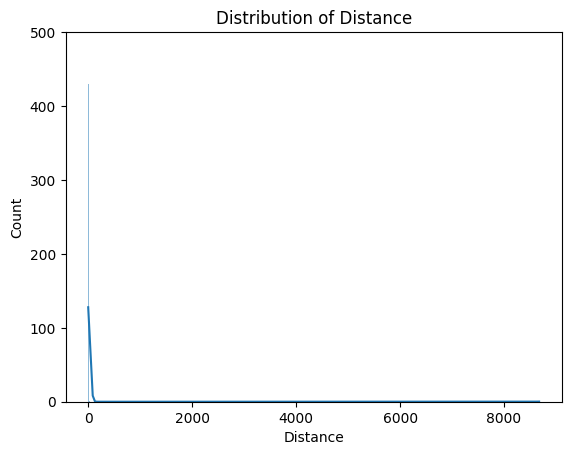

In [ ]:
# Plot the distribution of distance
sns.histplot(data =data, x= 'distance' ,kde=True)
plt.title('Distribution of Distance')
plt.xlabel('Distance')
plt.ylim(0, 500)
plt.show()

**Task**: Create a heatmap to visualize the correlations between the features in the 'data' DataFrame. Use Seaborn's `heatmap` function with annotations enabled and a "coolwarm" colormap. Add a title "Correlation Heatmap". Display the plot using `plt.show()`.

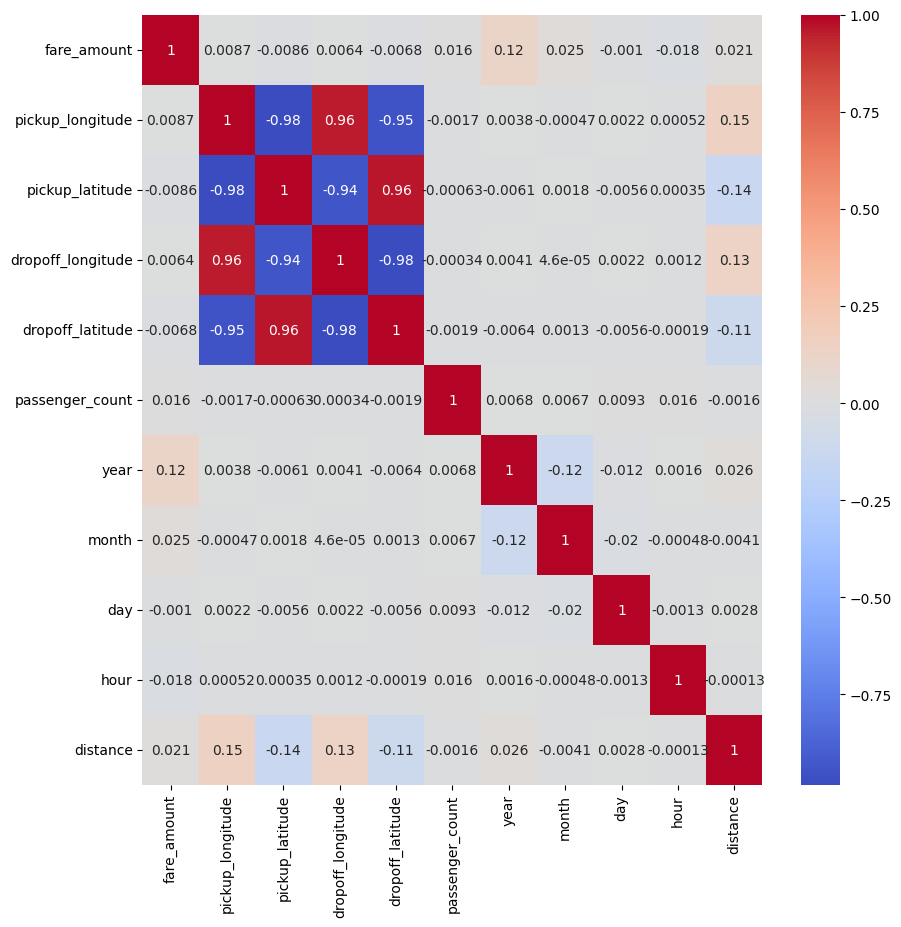

In [ ]:
# Plot the heatmap of correlations between features
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Task**: Create a line plot to visualize the average `fare_amount` by hour in the 'data' DataFrame. Calculate the average fare amount for each hour using the `groupby` method. Use Seaborn's `lineplot` function to create the plot. Add a title "Average Fare Amount by Hour", an x-axis label "Hour", and a y-axis label "Average Fare Amount". Display the plot using `plt.show()`.

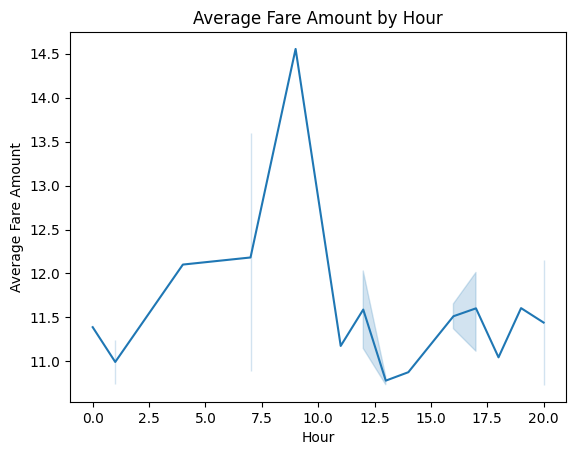

In [ ]:
# Plot the average fare_amount by hour
sns.lineplot(x='hour' , y= data.groupby('hour')['fare_amount'].mean() , data=data)
plt.xlabel('Hour')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Hour')
plt.show()

**Task**: Create a line plot to visualize the average `fare_amount` by month in the 'data' DataFrame. Calculate the average fare amount for each month using the `groupby` method. Use Seaborn's `lineplot` function to create the plot. Add a title "Average Fare Amount by Month", an x-axis label "Month", and a y-axis label "Average Fare Amount". Display the plot using `plt.show()`.

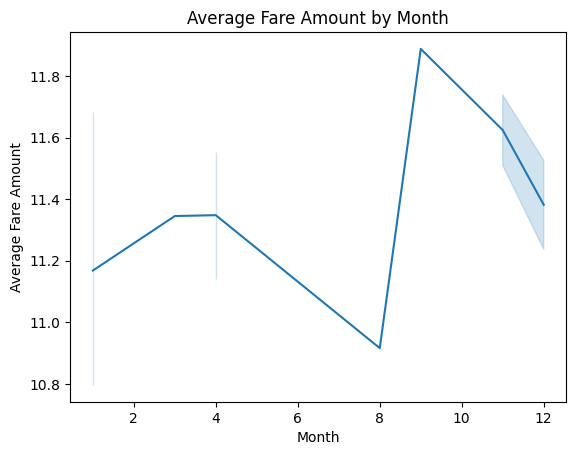

In [ ]:
# Plot the average fare_amount by month
sns.lineplot(x='month' , y= data.groupby('month')['fare_amount'].mean() , data=data)
plt.xlabel('Month')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Month')
plt.show()

**Task**: Create a line plot to visualize the average `fare_amount` by year in the 'data' DataFrame. Calculate the average fare amount for each year using the `groupby` method. Use Seaborn's `lineplot` function to create the plot. Add a title "Average Fare Amount by Year", an x-axis label "Year", and a y-axis label "Average Fare Amount". Display the plot using `plt.show()`.

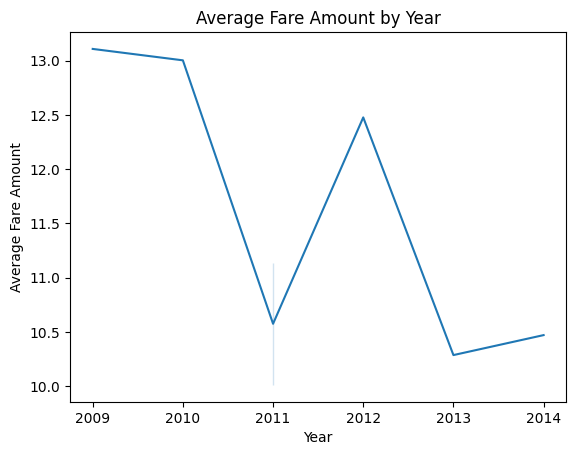

In [ ]:
# Plot the average fare_amount by month
sns.lineplot(x='year' , y= data.groupby('year')['fare_amount'].mean() , data=data)
plt.xlabel('Year')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Year')
plt.show()

**Task**: Remove outliers from the 'data' DataFrame, assuming data has already been cleaned for missing values and invalid coordinates. Apply the following conditions:
- Keep rows with 'fare_amount' between 1 and 200 (inclusive).
- Keep rows with 'distance' between 0.1 and 100 (inclusive).
- Keep rows with 'passenger_count' between 1 and 6 (inclusive).

In [ ]:
data = data[(data['fare_amount'].between(1, 200)) &
            (data['distance'].between(0.1, 100)) &
            (data['passenger_count'].between(1, 6))]

In [ ]:
len(data)

95913

# Train Test split

**Task**:

a. Define the features (X) by dropping the 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', and 'dropoff_latitude' columns from the 'data' DataFrame.

b. Scale the features using the `StandardScaler` from the `sklearn.preprocessing` module. Store the scaled features in a variable named `X_scaled`.

c. Define the target variable (y) as the 'fare_amount' column from the 'data' DataFrame.

d. Split the dataset into training and testing sets using the `train_test_split` function from the `sklearn.model_selection` module. Use an 80-20 split with a random state of 42. Store the split data in the variables `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Define the features and target variable
# a. Define the features (X)
X = data.drop(['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)

# b. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# c. Define the target variable (y)
y = data['fare_amount']

# d. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
X[:3]

,passenger_count,year,month,day,hour,distance
0,1,2009,6,15,17,1.030765
1,1,2010,1,5,16,8.450145
2,2,2011,8,18,0,1.389527


In [ ]:
X.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'distance'], dtype='object')

# Model Training

**Task**:

a. Train a Ridge Regression model with an alpha of 1.0 using the training data (X_train and y_train). Store the trained model in a variable named `ridge_model`.

b. Train a Linear Regression model using the training data (X_train and y_train). Store the trained model in a variable named `linear_model`.

In [ ]:
# Train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

a. Use the trained Ridge Regression model to make predictions on the testing data (X_test). Store the predictions in a variable named `ridge_preds`.

b. Use the trained Linear Regression model to make predictions on the testing data (X_test). Store the predictions in a variable named `linear_preds`.

In [ ]:
# Make predictions using the Ridge Regression model
ridge_preds = ridge_model.predict(X_test)

# Make predictions using the Linear Regression model
linear_preds = linear_model.predict(X_test)

**Task**:

a. Calculate the Root Mean Squared Error (RMSE) for the Ridge Regression model using the true values (y_test) and the predicted values (ridge_preds). Store the result in a variable named `ridge_rmse` and print it.

b. Calculate the Root Mean Squared Error (RMSE) for the Linear Regression model using the true values (y_test) and the predicted values (linear_preds). Store the result in a variable named `linear_rmse` and print it.


In [ ]:
# Calculate the RMSE for the Ridge Regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"Ridge Regression RMSE: {ridge_rmse}")

# Calculate the RMSE for the Linear Regression model
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
print(f"Linear Regression RMSE: {linear_rmse}")

Ridge Regression RMSE: 4.356858692634607
Linear Regression RMSE: 4.356843949734937


**Task**:

a. Perform hyperparameter tuning for the Ridge Regression model using GridSearchCV. Create a dictionary named `ridge_params` with the following keys: 'alpha' and 'solver'. The 'alpha' key should have a list of values: [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]. The 'solver' key should have a list of values: ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'].

b. Fit the GridSearchCV object with the scaled features (X_scaled) and target variable (y).

c. Get the best Ridge Regression model from the GridSearchCV results and store it in a variable named `best_ridge`.

d. Re-split the data using the scaled features (X_scaled) and target variable (y) with a test size of 0.2 and a random state of 42. Store the split data in the variables `X_train`, `X_test`, `y_train`, and `y_test`.

e. Train the best Ridge Regression model on the training data (X_train and y_train).

f. Make predictions on the testing data (X_test) and store the results in a variable named `ridge_preds`.

g. Calculate the RMSE for the best Ridge Regression model using the true values (y_test) and the predicted values (ridge_preds). Store the result in a variable named `ridge_rmse` and print it.

In [ ]:
# Perform hyperparameter tuning for Ridge Regression
# Perform hyperparameter tuning for Ridge Regression with additional parameters
ridge_params = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
grid_search = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_scaled, y)

# Get the best Ridge Regression model
best_ridge = grid_search.best_estimator_

# Re-split the data using the scaled features and updated dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the best Ridge Regression model on the training data
best_ridge.fit(X_train, y_train)


# Make predictions on the testing data
ridge_preds = best_ridge.predict(X_test)

# Calculate the RMSE for the best Ridge Regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"Best Ridge Regression RMSE: {ridge_rmse}")

Best Ridge Regression RMSE: 4.3568439512091235


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
